In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import torch as torch
import os
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import pixiedust
from torchvision import transforms,datasets,models
from collections import OrderedDict
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
import time
import matplotlib.image as mpimg

Pixiedust database opened successfully


In [2]:
%matplotlib inline

## Notas y recordatorios

* Por la forma en que se prepararon los datos renombre  temporalmente el paciente 120 a paciente 6(para mantener la continuidad de la muestra) y lo puse también como 6 en los diagnosticos.
* Similar al punto anterior pero con el paciente 121 y el 7
* Similar pero con el paciente 8

In [3]:
# for fast experimentation on slow computer limit the size of the sample
MAX_PATIENTS = 800 
MINI_BATCH_SIZE = 16 #curently not used for mini batch split but for deciding when to do backward and zero grad

In [4]:
DATA_DIRECTORY = "../datos/TOMOGRAFIAS/"
VALIDATION_FRACTION  = 0.10
DESIRED_DIAGNOSTICS = "fractura"
GPU = "cuda:1"

In [5]:
diagnosticos  = pd.read_excel(DATA_DIRECTORY+"RESUMEN TAC CEREBRALES.xlsx")
nombres_diagnosticos = diagnosticos.columns[1:-1]

In [6]:
diagnosticos.count()

paciente         1142
hemorragia        907
isquemia          907
fractura          907
masa              907
edema             906
observaciones     157
dtype: int64

In [7]:
diagnosticos.head(20)

,paciente,hemorragia,isquemia,fractura,masa,edema,observaciones
0,1,1.0,0.0,0.0,0.0,0.0,NaN
1,2,1.0,0.0,1.0,0.0,1.0,NaN
2,3,1.0,0.0,1.0,0.0,0.0,NaN
3,4,0.0,1.0,0.0,0.0,0.0,NaN
4,5,0.0,0.0,0.0,1.0,1.0,NaN
5,6,1.0,0.0,0.0,0.0,0.0,NaN
6,7,0.0,0.0,0.0,0.0,0.0,NaN
7,8,0.0,0.0,0.0,0.0,0.0,NaN
8,9,0.0,0.0,0.0,0.0,0.0,NaN
9,10,0.0,0.0,0.0,0.0,0.0,NaN


In [8]:
# diccionario cuya llave es el id de paciente y el valor una lista 
# donde cada elemento de la lista es la matriz de una i
diccionario_imagenes_pacientes = dict()
processed_patients = 0

for paciente in diagnosticos.paciente:
    if processed_patients >= MAX_PATIENTS:
        diagnosticos = diagnosticos.iloc[:processed_patients]
        break
    directorio_paciente = DATA_DIRECTORY+"paciente_"+str(paciente)
    
    # if patient directory is missing OR any of the diagnostics is null 
    #do not try to read images and delete it from diagnostics dataframe
    if not os.path.exists(directorio_paciente) or  diagnosticos[diagnosticos.paciente == paciente].iloc[:,0:6].isnull().values.any():
        diagnostics_row = diagnosticos[diagnosticos.paciente == paciente]
        diagnosticos.drop(int(diagnostics_row.index.values),axis=0,inplace=True)
        
        continue
    archivos_paciente = os.listdir(directorio_paciente)
    
    if len(archivos_paciente)>= 50:
        diagnostics_row = diagnosticos[diagnosticos.paciente == paciente]
        diagnosticos.drop(int(diagnostics_row.index.values),axis=0,inplace=True)
        
        continue
    
    lista_imagenes_paciente = []
    for archivo in archivos_paciente:
        if archivo.endswith(".jpg"):
            imagen = mpimg.imread(directorio_paciente+"/"+archivo)
            lista_imagenes_paciente.append(imagen)
            
    processed_patients += 1
            
    diccionario_imagenes_pacientes[paciente] = lista_imagenes_paciente
    

In [9]:
print("Total pacientes:",processed_patients)

Total pacientes: 715


In [10]:
diagnosticos.head(20)

,paciente,hemorragia,isquemia,fractura,masa,edema,observaciones
0,1,1.0,0.0,0.0,0.0,0.0,NaN
1,2,1.0,0.0,1.0,0.0,1.0,NaN
2,3,1.0,0.0,1.0,0.0,0.0,NaN
3,4,0.0,1.0,0.0,0.0,0.0,NaN
4,5,0.0,0.0,0.0,1.0,1.0,NaN
5,6,1.0,0.0,0.0,0.0,0.0,NaN
6,7,0.0,0.0,0.0,0.0,0.0,NaN
7,8,0.0,0.0,0.0,0.0,0.0,NaN
8,9,0.0,0.0,0.0,0.0,0.0,NaN
9,10,0.0,0.0,0.0,0.0,0.0,NaN


### Separacion "train-val"

In [11]:
diagonsticos_val = diagnosticos.sample(frac=VALIDATION_FRACTION)
diccionario_imagenes_pacientes_val = {llave:diccionario_imagenes_pacientes[llave] for llave in diagonsticos_val.paciente}

In [12]:
diagnosticos = diagnosticos[~diagnosticos.paciente.isin(diagonsticos_val.paciente)]
diccionario_imagenes_pacientes = {llave:diccionario_imagenes_pacientes[llave] for llave in diagnosticos.paciente}

In [13]:
print("Train size:",len(diagnosticos))
print("Val size:",len(diagonsticos_val))

Train size: 643
Val size: 72


### Proporcion de positivos

In [14]:
train_proportions = diagnosticos.iloc[:,1:-1].mean()
train_proportions

hemorragia    0.281493
isquemia      0.108865
fractura      0.065319
masa          0.018663
edema         0.146190
dtype: float64

In [15]:
val_proportions = diagonsticos_val.iloc[:,1:-1].mean()
val_proportions

hemorragia    0.305556
isquemia      0.083333
fractura      0.152778
masa          0.013889
edema         0.166667
dtype: float64

In [16]:
weight_multiplier = 10
positive_samples_weight = (1 - train_proportions[DESIRED_DIAGNOSTICS])*weight_multiplier
negative_samples_weight  = (weight_multiplier - positive_samples_weight)
print("positive weight",positive_samples_weight,"negative weight",negative_samples_weight)

positive weight 9.346811819595645 negative weight 0.6531881804043547


## Modelos y arquitecturas
### Arquitecturas experimental  DNC
* Alimentamos al modelo imagen por imagen y se presenta un solo diagnostico por paciente
* El controller de la DNC esta compuesto por una convnet

In [17]:
CONTROLLER_OUTPUT_SIZE = 128
READ_HEADS = 2

In [18]:
#TODO: cambiar valores quemados por valores parametrizados y calculos dependientes
class ConvController(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1,4,kernel_size=3,stride=1)
        self.fc1  =  torch.nn.Linear(262144,CONTROLLER_OUTPUT_SIZE)
        
        
    def forward(self,x):
        h = self.conv1(x)
        
        #flatten
        h =  x.view(-1,x.shape[1]*x.shape[2]*x.shape[3])
        h =  self.fc1(h)
        
        return h #h_t in my txt
    
class Controller(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv_controller = ConvController()
        self.fc1 = torch.nn.Linear(10,CONTROLLER_OUTPUT_SIZE)
        self.fc2 = torch.nn.Linear(2*CONTROLLER_OUTPUT_SIZE,CONTROLLER_OUTPUT_SIZE)
        
    def forward(self,x,read_vectors):
        h_conv = self.conv_controller(x)
        h_read_vectors = self.fc1(read_vectors)
        
        h_t = torch.cat((h_conv,h_read_vectors),dim=1)
        
        h_t =  torch.relu( h_t)
        h_t =  self.fc2(h_t) 
        
        return h_t

In [19]:

#TODO: cambiar valores quemados por valores parametrizados y calculos dependientes
#TODO: cordar por que en algun momento le puse bias = False a los pesos del vector de salida de la DNC


class DNC(torch.nn.Module):
    
    def __init__(self,controller,memory_size = (10,10),read_heads = 1,device="cpu"):
        super().__init__()
        self.controller = controller
        self.device = device
        self.N = memory_size[0] # number of memory locations
        self.W = memory_size[1] # word size of the memory 
        self.R = read_heads # number of read heads
        self.WS = 1 #not in the paper(they use 1), but used as a parametrizable number of write heads for further experiments
        self.interface_vector_size = (self.W*self.R) + (self.W*self.WS) + (2*self.W) + (5*self.R) + 3
        
        # inicialization st to random just for testing, remember to put on zeros
        #self.memory_matrix = self.memory_matrix =  nn.Parameter(torch.zeros(size=memory_size),requires_grad= False) 
        
        #1024 es el tamaño del vector de salida del controlador, 1 es el tamaño de salida de la dnc
        self.output_vector_linear = torch.nn.Linear(CONTROLLER_OUTPUT_SIZE,1,bias=True) #W_y 
        self.interface_vector_linear = torch.nn.Linear(CONTROLLER_OUTPUT_SIZE,self.interface_vector_size,bias=True) #W_ξ
        self.read_vectors_to_output_linear = torch.nn.Linear(self.R*self.W,1,bias = True) #W_r in my txt
        
        self.read_keys = torch.Tensor(size=(self.R,self.W)).requires_grad_(False) # k_r in my txt
        self.read_strenghts = torch.Tensor(size=(self.R,1)).requires_grad_(False) #β_r
        
        #self.read_weighting = torch.Tensor(torch.zeros(size=(self.R,self.N))).requires_grad_(False).to(device) #r_w
        
        self.write_key = torch.Tensor(size=(1,self.W)).requires_grad_(False) # k_w in my txt
        self.write_strenght = torch.Tensor(size=(1,1)).requires_grad_(False) # β_w
        
        #self.write_weighting = torch.Tensor(torch.zeros(size=(1,self.N))).requires_grad_(False) # w_w
        
        #self.usage_vector = torch.Tensor(torch.zeros(size=(1,self.N))).requires_grad_(False) #u_t
        
        self.memory_matrix_ones = torch.Tensor(torch.ones(size=memory_size)).requires_grad_(True).to(device) #E on paper
        
        self.reset()
        
    def forward(self,x,read_vectors):
        
        h_t = self.controller(x,read_vectors) #controller output called ht in the paper
        
        output_vector = self.output_vector_linear(h_t) # called Vt in the paper(υ=Wy[h1;...;hL]) v_o_t in my txt
        interface_vector = self.interface_vector_linear(h_t).data #called ξt(ksi) in the paper ,ξ_t in my txt
        
        self.read_keys.data = interface_vector[0,0:self.R*self.W].view((self.R,self.W)) #k_r in my txt
        
        #clamp temporary added because the exp was returning inf  values
        read_strenghts =  torch.clamp( interface_vector[0,self.R*self.W:self.R*self.W+self.R].view((self.R,1)),max=85)
        self.read_strenghts.data = self.oneplus(read_strenghts) #β_r
        
        self.write_key.data = interface_vector[0,self.R*self.W+self.R:self.R*self.W+self.R+self.W].view((1,self.W)) # k_w
        
        write_strenght = torch.clamp(interface_vector[:,self.R*self.W+self.R+self.W:self.R*self.W+self.R+self.W + 1].view((1,1)),max=85)
        self.write_strenght.data = self.oneplus(write_strenght) #β_w
        
        erase_vector = interface_vector[0,self.R*self.W+self.R+self.W + 1: self.R*self.W+self.R+self.W + 1 + self.W].view((1,self.W))
        erase_vector = torch.sigmoid(erase_vector) #e_t
        
        write_vector = interface_vector[0,self.R*self.W+self.R+self.W + 1 + self.W:self.R*self.W+self.R+self.W + 1 + 2*self.W].view((1,self.W)) #v_t
        
        free_gates  =  interface_vector[0,self.R*self.W+self.R+self.W + 1 + 2*self.W:self.R*self.W+2*self.R+self.W + 1 + 2*self.W].view((self.R,1)) #f_t
        free_gates =   torch.sigmoid(free_gates)
        
        allocation_gate = interface_vector[0,self.R*self.W+2*self.R+self.W + 1 + 2*self.W:self.R*self.W+2*self.R+self.W + 1 + 2*self.W+1]
        allocation_gate = torch.sigmoid(allocation_gate)
        
        write_gate = interface_vector[0,self.R*self.W+2*self.R+self.W + 1 + 2*self.W+1:self.R*self.W+2*self.R+self.W + 1 + 2*self.W+2]
        write_gate = torch.sigmoid( write_gate)
        
        
        # Escritura
        # TODO: verificar y/o experimentar si el ordern es :primero escribir y luego leer de la memoria(asi parece en el pazper)
        retention_vector = (1.0 - free_gates * self.read_weighting).prod(dim=0)
        self.usage_vector.data = (self.usage_vector +self.write_weighting - (self.usage_vector *self.write_weighting))*retention_vector #u_t
        allocation_weighting = self.calc_allocation_weighting(self.usage_vector)
        write_content_weighting = self.content_lookup(self.memory_matrix,self.write_key,self.write_strenght)

        self.write_weighting.data =  write_gate*(  
            (allocation_gate * allocation_weighting) +  ((1- allocation_gate)*write_content_weighting))
        
        new_memory_matrix = self.memory_matrix*(self.memory_matrix_ones - torch.matmul(self.write_weighting.t(),erase_vector)) + torch.matmul(self.write_weighting.t(),write_vector)
        
        self.memory_matrix.data = new_memory_matrix
        
        # read by content weithing(attention by similarity)
        read_content_weighting = self.content_lookup(self.memory_matrix,self.read_keys,self.read_strenghts)
        
        #read weithing is a combination of reading modes,TODO:add temporal attention not just by similarity
        self.read_weighting.data = read_content_weighting
        
        read_vectors = torch.matmul(self.read_weighting,self.memory_matrix).view((1,self.R*self.W)) #r in my txt
        read_heads_to_output = self.read_vectors_to_output_linear(read_vectors) #v_r_t in my t xt
        
        #TODO: experiment and decide if maintain sigmoid
        y_t = torch.sigmoid(output_vector + read_heads_to_output)
        return y_t,read_vectors
    
    def oneplus(self,x):
        # apply oneplus operation to a tensor to constrain it's elements to [1,inf)
        #TODO: check numerical statiliby as exp is returning inf for numbers like 710,emporary added clamp to 85
        return torch.log(1+torch.exp(x)) + 1
    
    def content_lookup(self,matrix,keys,strengths):
        # returns a probability distribution over the memory locations 
        # with higher probability to memory locations with bigger similarity to the keys
        # bigger strenght make more aggresive distributions ,for example a distribution (0.2,0.3,0.5) with
        # bigger strenght becomes (0.1,0.12,0.78)
        # returns tensor of shape (read keys,memory size) = (R,N)
        keys_norm =  torch.sqrt(torch.sum(keys**2,dim=1).unsqueeze(dim=1))
        matrix_norm = torch.sqrt(torch.sum(matrix**2,dim=1))
        norms_multiplication = keys_norm*matrix_norm
        # calc cosine similarity between keys and memory locations(1e-6 is used avoiding div by 0)
        divide_zero_prevent_factor = torch.zeros_like(norms_multiplication).add_(1e-6)
        cosine_similarity = torch.matmul(keys,matrix.t())/(torch.max(norms_multiplication,divide_zero_prevent_factor))
        
        # do a "strenght" softmax to calculate the probability distribution
        numerator = torch.exp(cosine_similarity*strengths)
        denominator = numerator.sum(dim=1).unsqueeze(dim=1)

        distribution = numerator/denominator
        
        return distribution
    
    def calc_allocation_weighting(self,usage_vector):
        #print("usage vector",usage_vector)
        _,free_list = torch.topk(-usage_vector,self.N,dim=1) #φt indices of memory locations ordered by usage
        #print("free list",free_list)
        free_list = free_list.view(-1)
        #print("reshaped free list",free_list)
        _,ordered_free_list =  torch.topk(-free_list,self.N)
        ordered_free_list = ordered_free_list.view(-1)
        #print("ordered free list",ordered_free_list)
        ordered_usage_vector = usage_vector[:,free_list]
        #print("ordered usage vector",ordered_usage_vector)
        ordered_usage_vector_cumulative_product = torch.ones(size=(1,self.N+1)).to(device)
        #print(ordered_usage_vector_cumulative_product)
        #print("cumprod ",ordered_usage_vector.cumprod(dim=1))
        ordered_usage_vector_cumulative_product[0,1:] = ordered_usage_vector.cumprod(dim=1)
        #print(ordered_usage_vector_cumulative_product)
        
        allocation_weighting = (1 - usage_vector)*ordered_usage_vector_cumulative_product[0,ordered_free_list]
        
        return  allocation_weighting
    
    def reset(self):
        self.memory_matrix =  torch.Tensor(torch.zeros(size=(self.N,self.W))).requires_grad_(True).to(device) 
        self.read_weighting = torch.Tensor(torch.zeros(size=(self.R,self.N))).requires_grad_(True).to(device) #r_w
        self.write_weighting = torch.Tensor(torch.zeros(size=(1,self.N))).requires_grad_(True).to(device) # w_w
        self.usage_vector = torch.Tensor(torch.zeros(size=(1,self.N))).requires_grad_(True).to(device) #u_t

## Experimentos
* Experimentando con DNC alimentando una imagen a la vez en orden aleatorio con pacientes también en orden aleatorio

In [20]:
device = torch.device(GPU if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [21]:
EPOCHS = 5

In [22]:
conv_controller = Controller()
dnc_model = DNC(controller=conv_controller,memory_size = (5,5),read_heads=2,device=device).to(device)

In [23]:
base_criterion = torch.nn.BCELoss()
def loss_function(y,y_hat,last_flag):
    #print(y,y_hat,last_flag)
    #base_criterion = torch.nn.BCELoss()
    return torch.full_like(y,last_flag) * base_criterion(y,y_hat)
    #return base_criterion(y,y_hat)

In [24]:
criterion = loss_function
optimizer = optim.Adam(dnc_model.parameters(),lr=0.001)


total_accuracies  = []
for epoch in range(EPOCHS):
    epoch_predictions = []
    epoch_real_values = []
    # en cada epoch procesar los pacientes en orden aleatorio
    pacientes = np.random.choice(np.array(diagnosticos.paciente),size= len(diagnosticos.paciente),replace=False)
    
    conteo_pacientes = 0
    for paciente in pacientes:
        #TODO: remover esta validacion, solo puesta para probar una unica iteracion en compu lenta
        if conteo_pacientes >= 99999999:
            break
            
        dnc_model.reset()
        read_vectors = torch.zeros(size=(1,dnc_model.R*dnc_model.W)).to(device)
        
        imagenes_paciente = diccionario_imagenes_pacientes.get(paciente)
        diagnostico_hemorragia_paciente = np.array(float(diagnosticos[diagnosticos.paciente==paciente].hemorragia))
        tensor_diagnostico_hemorragia_paciente = torch.Tensor(diagnostico_hemorragia_paciente).to(device)
        
        indices_imagenes_pacientes = np.arange(0,len(imagenes_paciente)-1,step=1)
        indices_aleatorios_imagenes = np.random.choice(indices_imagenes_pacientes,len(indices_imagenes_pacientes),replace=False)
        
        losses = []
        for indice in indices_aleatorios_imagenes:
            last_image =  int(indice  == indices_aleatorios_imagenes[-1])
            
            #optimizer.zero_grad()
            
            imagen_paciente = imagenes_paciente[indice]
            
            if imagen_paciente.shape != (512,512):
                #TODO: tread different image sizes with reshaping, resizing(or other ideas)
                continue
                
            tensor_imagen_paciente =  torch.unsqueeze(
                torch.unsqueeze( torch.Tensor(imagen_paciente),dim=0),dim=1).to(device)
            
            #print("Alimentando paciente {} e imagen {} al modelo".format(paciente,indice),imagen_paciente.shape)
            
            diagnostico_hemorragia_aproximado,read_vectors = dnc_model(tensor_imagen_paciente,read_vectors)
            loss = criterion(diagnostico_hemorragia_aproximado,tensor_diagnostico_hemorragia_paciente,last_image)
            
            losses.append(loss.view((1,1)))
            
            if last_image:
                y_hat = diagnostico_hemorragia_aproximado.data.cpu().numpy()[0][0]
                y_hat_hard = float(y_hat >= 0.5)
                epoch_predictions.append(y_hat_hard)
                epoch_real_values.append(float(diagnostico_hemorragia_paciente))
                
                #print("--Flag ultima imagen:{} diagnostico:{} valor real{}".format(last_image,y_hat,diagnostico_hemorragia_paciente))
                optimizer.zero_grad()
                
                patient_loss = torch.cat(losses).sum()
                
                patient_loss.backward()
                optimizer.step()

                
        conteo_pacientes += 1
            
    epoch_predictions = np.array(epoch_predictions)
    epoch_real_values = np.array(epoch_real_values)
    correct_predictions = epoch_predictions == epoch_real_values
    accuracy = np.average(correct_predictions)
    total_accuracies.append(accuracy)
    print("Epoch {}: accuracy {}".format(epoch,accuracy),epoch_predictions,epoch_real_values)

print(np.average(total_accuracies))

In [25]:
#TODO: averiguar por que salen 6 tensores de parametros si solo se han declarado 3(al momento de correr lap rueba)
train_parmams = list(dnc_model.named_parameters())

for train_param in train_parmams:
    print(train_param[0])

controller.conv_controller.conv1.weight
controller.conv_controller.conv1.bias
controller.conv_controller.fc1.weight
controller.conv_controller.fc1.bias
controller.fc1.weight
controller.fc1.bias
controller.fc2.weight
controller.fc2.bias
output_vector_linear.weight
output_vector_linear.bias
interface_vector_linear.weight
interface_vector_linear.bias
read_vectors_to_output_linear.weight
read_vectors_to_output_linear.bias


In [26]:
dnc_model.memory_matrix.data


tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:1')

Meta (por detallar))
* L temporal link matrix

In [27]:
###

### LSTM con conv
* Experimentando con lstm alimentando una imagen a la vez en orden aleatorio con pacientes también en orden aleatorio

El vector de entrada de la lstm es un vector producido por una convnet

In [28]:
CONVNET_OUTPUT_SIZE = 128 #1000 #1024
CONVNET_HIDDEN_SIZE = 512

LSTM_HIDDEN_SIZE = 600

FINAL_LAYER_SIZE = 512

In [29]:
architecture = 'vgg19'
#architecture = 'resnet18'
architecture_constructor = getattr(models,architecture)
model  =  architecture_constructor(pretrained=True)
features_size = 0 #model.classifier[0].in_features 

if  isinstance(model.classifier,nn.Sequential):
    features_size = model.classifier[0].in_features
elif isinstance(model.classifier,nn.Module):
    features_size = model.classifier.in_features

print("Total layers:",len(list(model.parameters())))

Total layers: 38


In [30]:

#freeze parameters so we don't backpropagete  through them
layers_to_freeze = 40
layer_num = 0
layers_freezed = 0
for parameter in model.parameters():
    if layer_num >= layers_to_freeze:
        break
    parameter.requires_grad = False
    layers_freezed+=1
        
    layer_num += 1
print("froze ",layers_freezed," of ",len([l for l in model.parameters()]))

froze  38  of  38


In [31]:
model_classifier = torch.nn.Sequential(OrderedDict([
    ("fc1",torch.nn.Linear(features_size,CONVNET_OUTPUT_SIZE)), #original model only had this
    ("relu",torch.nn.ReLU()),
    ("fc2",torch.nn.Linear(CONVNET_OUTPUT_SIZE,CONVNET_OUTPUT_SIZE))#,
    #("relu2",torch.nn.ReLU()),
    #("fc3",torch.nn.Linear(CONVNET_OUTPUT_SIZE,CONVNET_OUTPUT_SIZE))
]))

model.classifier = model_classifier

In [32]:
experiment_string = DESIRED_DIAGNOSTICS+"_"+architecture+"_"+"2"
print(experiment_string)

fractura_vgg19_2


In [33]:
class ConvLSTM(nn.Module):
    
    def __init__(self,conv_net,lstm_layers=1):
        super().__init__()
        self.conv_net = conv_net
        self.lstm = nn.LSTM(input_size= CONVNET_OUTPUT_SIZE,hidden_size = LSTM_HIDDEN_SIZE,num_layers=lstm_layers,batch_first = True)
        self.lstm_layers = lstm_layers
        self.lstm_hidden_size = LSTM_HIDDEN_SIZE
        
        self.output_linear = nn.Linear(LSTM_HIDDEN_SIZE,1)
    
    def forward(self,x,hidden):
        x = self.conv_net(x)
        x = x.unsqueeze(0)
        x,hidden = self.lstm(x,hidden)
        x = x.contiguous().view(-1,self.lstm_hidden_size)
        
        x = self.output_linear(x)
        #x = torch.sigmoid(self.output_linear(x))
        
        return x,hidden
    
    def init_hidden(self):
        weigths =  next(self.lstm.parameters())
        
        
        hidden = ( 
            weigths.new(self.lstm_layers,1,LSTM_HIDDEN_SIZE).zero_().to(device)
        ,   weigths.new(self.lstm_layers,1,LSTM_HIDDEN_SIZE).zero_().to(device)
                 )
        
        return hidden

In [34]:
# ya que estamos usando densenet121 transformamos los datos de entrada para que tengan el tamaño adecuado
# y se normalicen usando los valores de media y desviación estandar del dataset usado en densenet
train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

val_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])


In [35]:
conv_lstm = ConvLSTM(model,lstm_layers=1)
conv_lstm.to(device)

base_criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor(
    [positive_samples_weight]).to(device))
optimizer = optim.Adam(model.parameters(),lr=0.00030)

In [36]:
total_accuracies  = []
val_total_accuracies  = []
total_f1_accuracies = []
val_total_f1_accuracies = []
total_losses = []
individual_accuracies = []
val_individual_accuracies = []
individual_f1_accuracies = []
val_individual_f1_accuracies = []

In [37]:
individual_precisions = []
val_individual_precisions = []
individual_recalls = []
val_individual_recalls = []

In [38]:
EPOCHS = 100

for param_group in optimizer.param_groups:
        param_group['lr'] = 0.00002

In [39]:
for param_group in optimizer.param_groups:
        param_group['lr'] = 0.00001

In [40]:
def calc_accuracy(y_pred,y_real):
    "for calculating the accurracy of multiple columns"
    assert y_pred.shape[1] == y_real.shape[1]
    
    num_columns = y_pred.shape[1]
    
    accuracies = []
    for i in range(num_columns):
        
        colum_acc = accuracy_score(y_real[:,i],y_pred[:,i])
        accuracies.append(colum_acc)
        
    return accuracies, np.mean(np.array(accuracies))

def calc_f1_score(y_pred,y_real):
    "for calculating the f1 acc score of multiple columns"
    assert y_pred.shape[1] == y_real.shape[1]
    
    num_columns = y_pred.shape[1]
    
    accuracies = []
    for i in range(num_columns):
        
        colum_acc = f1_score(y_real[:,i],y_pred[:,i])
        accuracies.append(colum_acc)
        
    return accuracies, np.mean(np.array(accuracies))

def calc_score(y_pred,y_real,score_func):
    "for calculating the f1 acc score of multiple columns"
    assert y_pred.shape[1] == y_real.shape[1]
    
    num_columns = y_pred.shape[1]
    
    accuracies = []
    for i in range(num_columns):
        
        colum_acc = score_func(y_real[:,i],y_pred[:,i])
        accuracies.append(colum_acc)
        
    return accuracies, np.mean(np.array(accuracies))

In [41]:
#conv_lstm.load_state_dict(torch.load(experiment_string))

In [42]:



conv_lstm.train()


for epoch in range(EPOCHS):
    iteration_number = 0
    epoch_start  = time.time()
    conv_lstm.train()
    
    epoch_predictions = []
    epoch_real_values = []
    val_real_values = []
    val_predictions = []
    epoch_losses = []
    # en cada epoch procesar los pacientes en orden aleatorio
    pacientes = np.random.choice(np.array(diagnosticos.paciente),size= len(diagnosticos.paciente),replace=False)
    
    conteo_pacientes = 0
    for paciente in pacientes:
        
            
        h = conv_lstm.init_hidden()
        
        
        h = tuple([each.data for each in h])
        #conv_lstm.zero_grad()
        
        imagenes_paciente = diccionario_imagenes_pacientes.get(paciente)
        diagnostico_hemorragia_paciente = np.array(float(diagnosticos[diagnosticos.paciente==paciente].hemorragia))
        vector_diagnostico_paciente = np.array(diagnosticos[diagnosticos.paciente==paciente][[DESIRED_DIAGNOSTICS]])
        tensor_diagnostico_paciente = torch.Tensor(vector_diagnostico_paciente).view((1,1)).to(device)
        
        tensor_diagnostico_hemorragia_paciente = torch.Tensor(diagnostico_hemorragia_paciente).view((1,1)).to(device)
        
        indices_imagenes_pacientes = np.arange(0,len(imagenes_paciente)-1,step=1)
        indices_aleatorios_imagenes = np.random.choice(indices_imagenes_pacientes,len(indices_imagenes_pacientes),replace=False)
        
        losses = []
        for indice in indices_aleatorios_imagenes:
            #h = tuple([each.data for each in h])
            #print(paciente,indice)
            last_image =  int(indice  == indices_aleatorios_imagenes[-1])
            
            #optimizer.zero_grad()
            
            imagen_paciente =  np.expand_dims(imagenes_paciente[indice],2)
            imagen_paciente =  np.repeat(imagen_paciente,3,axis=2)
            #plt.imshow(imagen_paciente)
            #plt.show()
            
            tensor_imagen_paciente =  train_data_transforms(imagen_paciente).unsqueeze(0).to(device)
            #plt.imshow(np.squeeze(tensor_imagen_paciente.permute(2,3,1,0).cpu().numpy()))
            #plt.show()
            #print("printed it")
            #print("Alimentando paciente {} e imagen {} al modelo".format(paciente,indice),imagen_paciente.shape)
            
            diagnostico_aproximado,h  = conv_lstm(tensor_imagen_paciente,h)
            prob_diagnostico_aproximado = torch.sigmoid(diagnostico_aproximado)
            diagnostico_hemorragia_aproximado = diagnostico_aproximado[:,0]
            
            
            #loss = base_criterion(diagnostico_hemorragia_aproximado,tensor_diagnostico_hemorragia_paciente)
            
            #losses.append(loss.view((1,1)))
            
            if last_image:
                
                loss =  base_criterion(diagnostico_aproximado,tensor_diagnostico_paciente)
                loss.backward()
                #nn.utils.clip_grad_norm_(conv_lstm.lstm.parameters(), 5.0)
                #optimizer.step()
                
                vector_y_hat_hard = prob_diagnostico_aproximado >= 0.5
                
                #print(torch.sigmoid(diagnostico_aproximado).data,tensor_diagnostico_paciente.data)
                y_hat = diagnostico_hemorragia_aproximado.data.cpu().numpy()[0]
                y_hat_hard = float(y_hat >= 0.5)
                
                epoch_predictions.append(vector_y_hat_hard.data.cpu().numpy()[0])
                epoch_real_values.append(vector_diagnostico_paciente[0])
                
                
                #print("--Flag ultima imagen:{} diagnostico:{} valor real{}".format(last_image,y_hat,diagnostico_hemorragia_paciente))
                #optimizer.zero_grad()
                
                #patient_loss = torch.cat(losses).mean()
                
                
                #patient_loss.backward()
                #loss.backward()
                #nn.utils.clip_grad_norm_(conv_lstm.lstm.parameters(), 5.0)
                #optimizer.step()
                
                epoch_losses.append(loss.data.cpu().numpy())

                
        conteo_pacientes += 1
        
        
        
            
    #epoch_predictions = np.array(epoch_predictions)
    #epoch_real_values = np.array(epoch_real_values)
    #correct_predictions = epoch_predictions == epoch_real_values
    #accuracy = np.average(correct_predictions)
        if iteration_number % MINI_BATCH_SIZE == 0 or iteration_number == len(pacientes)-9:
            nn.utils.clip_grad_norm_(conv_lstm.lstm.parameters(), 5.0)
            optimizer.step()
            conv_lstm.zero_grad()
            
            
        
        iteration_number += 1
    accuracies,average_accuracy = calc_score(np.array(epoch_predictions),np.array(epoch_real_values),accuracy_score)
    precision_accs,average_prec_acc = calc_score(np.array(epoch_predictions),np.array(epoch_real_values),precision_score)
    recall_accs,average_recall_acc = calc_score(np.array(epoch_predictions),np.array(epoch_real_values),recall_score)
    f1_accs,average_f1_acc = calc_score(np.array(epoch_predictions),np.array(epoch_real_values),f1_score)
    
    
    epoch_avg_loss = np.average(epoch_losses)
    total_losses.append(epoch_avg_loss)
    
    total_accuracies.append(average_accuracy)
    individual_accuracies.append(accuracies)
    individual_precisions.append(precision_accs)
    individual_recalls.append(recall_accs)
    total_f1_accuracies.append(average_f1_acc)
    individual_f1_accuracies.append(f1_accs)
    
    conv_lstm.eval()
    for paciente in diagonsticos_val.paciente:
        imagenes_paciente = diccionario_imagenes_pacientes_val[paciente]
        
            
        h = conv_lstm.init_hidden()
        
        
        h = tuple([each.data for each in h])
        #conv_lstm.zero_grad()
        
        for indice in range(len(imagenes_paciente)):
            imagen_paciente =  np.expand_dims(imagenes_paciente[indice],2)
            imagen_paciente =  np.repeat(imagen_paciente,3,axis=2)
               
            tensor_imagen_paciente =  val_data_transforms(imagen_paciente).unsqueeze(0).to(device)
            
            
            #print("Alimentando paciente {} e imagen {} al modelo".format(paciente,indice),imagen_paciente.shape)
            
            diagnostico_aproximado,h  = conv_lstm(tensor_imagen_paciente,h)
            prob_diagnostico_aproximado = torch.sigmoid(diagnostico_aproximado).detach()
            
            vector_y_hat_hard = prob_diagnostico_aproximado >= 0.5
            
            if indice == len(imagenes_paciente)-1:
                val_predictions.append(vector_y_hat_hard.data.cpu().numpy()[0])
            #print(diagonsticos_val[diagonsticos_val.paciente==paciente],vector_y_hat_hard)
    
        vector_diagnostico_paciente = np.array(diagonsticos_val[diagonsticos_val.paciente==paciente][[DESIRED_DIAGNOSTICS]])
        val_real_values.append(vector_diagnostico_paciente[0])
      
    
    val_accuracies,val_average_accuracy = calc_score(np.array(val_predictions),np.array(val_real_values),accuracy_score)
    val_precision_accs,val_average_prec_acc = calc_score(np.array(val_predictions),np.array(val_real_values),precision_score)
    val_recall_accs,val_average_recall_acc = calc_score(np.array(val_predictions),np.array(val_real_values),recall_score)
    val_f1_accs,val_average_f1_acc = calc_score(np.array(val_predictions),np.array(val_real_values),f1_score)
    
    val_total_accuracies.append(val_average_accuracy)
    val_individual_accuracies.append(val_accuracies)
    val_individual_precisions.append(val_precision_accs)
    val_individual_recalls.append(val_recall_accs)
    val_individual_f1_accuracies.append(val_f1_accs)
    
    torch.save(conv_lstm.state_dict(), "./model_{}.chpk".format(experiment_string))
    epoch_end  = time.time()
    print("Epoch {}:individual accs:[{}] avg accuracy {:.3f} loss:{:.3f} avg val acc:{:.3f} time {}".format(epoch,
                                                                                                        np.around(accuracies,decimals=3),
                                                                                                        average_accuracy,epoch_avg_loss,
                                                                                                        val_average_accuracy,epoch_end-epoch_start))

/home/luis/anaconda2/envs/pytorch_challenge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/luis/anaconda2/envs/pytorch_challenge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 0:individual accs:[[0.67]] avg accuracy 0.670 loss:1.063 avg val acc:0.847 time 200.2038881778717
Epoch 1:individual accs:[[0.935]] avg accuracy 0.935 loss:1.037 avg val acc:0.847 time 198.76528978347778
Epoch 2:individual accs:[[0.935]] avg accuracy 0.935 loss:1.020 avg val acc:0.847 time 197.4124584197998
Epoch 3:individual accs:[[0.935]] avg accuracy 0.935 loss:1.006 avg val acc:0.847 time 197.27628540992737
Epoch 4:individual accs:[[0.935]] avg accuracy 0.935 loss:1.002 avg val acc:0.847 time 197.40630650520325
Epoch 5:individual accs:[[0.935]] avg accuracy 0.935 loss:0.980 avg val acc:0.847 time 197.41934657096863
Epoch 6:individual accs:[[0.918]] avg accuracy 0.918 loss:0.956 avg val acc:0.847 time 197.04617834091187
Epoch 7:individual accs:[[0.907]] avg accuracy 0.907 loss:0.950 avg val acc:0.861 time 197.20109581947327
Epoch 8:individual accs:[[0.844]] avg accuracy 0.844 loss:0.929 avg val acc:0.861 time 197.08338713645935
Epoch 9:individual accs:[[0.86]] avg accuracy 0.8

Epoch 78:individual accs:[[0.974]] avg accuracy 0.974 loss:0.454 avg val acc:0.875 time 195.60192823410034
Epoch 79:individual accs:[[0.961]] avg accuracy 0.961 loss:0.452 avg val acc:0.861 time 195.79867887496948
Epoch 80:individual accs:[[0.969]] avg accuracy 0.969 loss:0.439 avg val acc:0.861 time 195.79014992713928
Epoch 81:individual accs:[[0.972]] avg accuracy 0.972 loss:0.432 avg val acc:0.861 time 195.8261742591858
Epoch 82:individual accs:[[0.977]] avg accuracy 0.977 loss:0.428 avg val acc:0.875 time 195.75085043907166
Epoch 83:individual accs:[[0.972]] avg accuracy 0.972 loss:0.433 avg val acc:0.875 time 195.66674995422363
Epoch 84:individual accs:[[0.969]] avg accuracy 0.969 loss:0.429 avg val acc:0.861 time 195.58167147636414
Epoch 85:individual accs:[[0.974]] avg accuracy 0.974 loss:0.430 avg val acc:0.861 time 195.6233353614807
Epoch 86:individual accs:[[0.966]] avg accuracy 0.966 loss:0.429 avg val acc:0.861 time 195.55590677261353
Epoch 87:individual accs:[[0.975]] avg 

In [43]:
torch.save(conv_lstm.state_dict(), "./model_{}.chpk".format(experiment_string))

In [44]:
individual_accuracies_tensor = np.asarray(individual_accuracies)
val_individual_accuracies_tensor = np.asarray(val_individual_accuracies)
individual_precisions_tensor = np.asarray(individual_precisions)
individual_recalls_tensor = np.asarray(individual_recalls)
individual_f1_accuracies_tensor = np.asarray(individual_f1_accuracies)
val_individual_precisions_tensor = np.asarray(val_individual_precisions)
val_individual_recalls_tensor = np.asarray(val_individual_recalls)
val_individual_f1_accuracies_tensor = np.asarray(val_individual_f1_accuracies)

## Plots

### Training loss

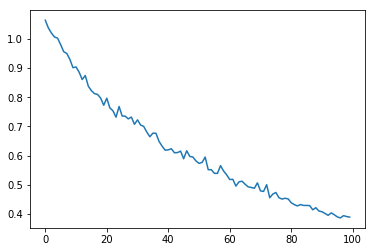

In [45]:
plt.plot(total_losses)
plt.show()

### Training average accuracy

Accuracies of al diagnostics averaged

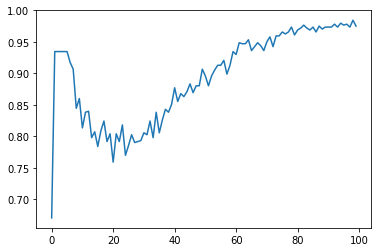

In [46]:
plt.plot(total_accuracies)
plt.show()

### Val average accuracy

Accuracies of al diagnostics averaged

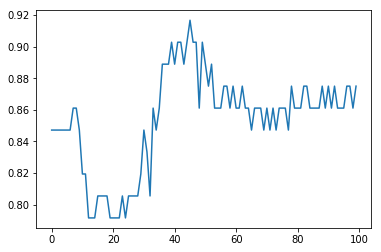

In [47]:
plt.plot(val_total_accuracies)
plt.show()

### Individual accuracies plots

train plots 1
0


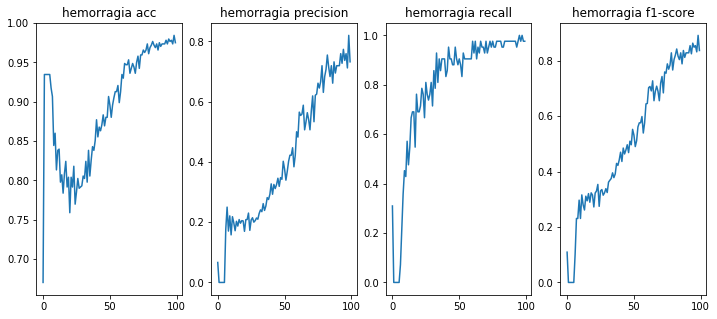

validation plots


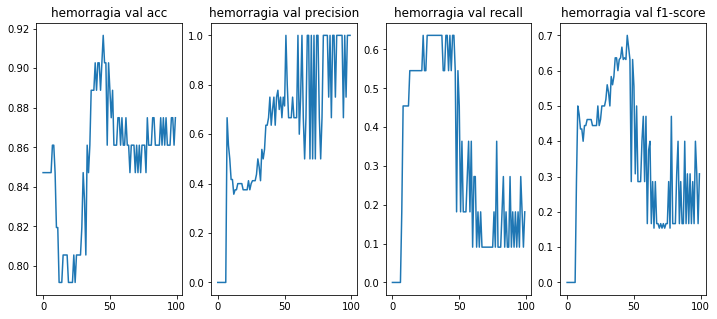

In [48]:
number_of_plots = individual_accuracies_tensor.shape[1]  
f,plots = plt.subplots(number_of_plots,4,sharex=True,figsize= (12,5))
print("train plots",number_of_plots)
for i in range(number_of_plots):
    print(i)
    plots[0].plot(individual_accuracies_tensor[:,i])
    plots[0].set_title(nombres_diagnosticos[i]+ " acc")
    
    plots[1].plot(individual_precisions_tensor[:,i])
    plots[1].set_title(nombres_diagnosticos[i]+" precision")
    
    plots[2].plot(individual_recalls_tensor[:,i])
    plots[2].set_title(nombres_diagnosticos[i]+" recall")
    
    plots[3].plot(individual_f1_accuracies_tensor[:,i])
    plots[3].set_title(nombres_diagnosticos[i]+" f1-score")
    
    
plt.show()
print("validation plots")
number_of_plots =  individual_accuracies_tensor.shape[1]  
f,plots = plt.subplots(number_of_plots,4,sharex=True,figsize= (12,5))

for i in range(number_of_plots):
    plots[0].plot(val_individual_accuracies_tensor[:,i])
    plots[0].set_title(nombres_diagnosticos[i]+ " val acc")
    
    plots[1].plot(val_individual_precisions_tensor[:,i])
    plots[1].set_title(nombres_diagnosticos[i]+" val precision")
    
    plots[2].plot(val_individual_recalls_tensor[:,i])
    plots[2].set_title(nombres_diagnosticos[i]+" val recall")
    
    plots[3].plot(val_individual_f1_accuracies_tensor[:,i])
    plots[3].set_title(nombres_diagnosticos[i]+" val f1-score")
    
    
    
plt.show()

## Resultados
* El mejor resultado hasta ahora ha sido no congelar pesos(entranar toda la convnet densenet121) agregandole una sola capa fully connected de salida, y 3 layers en la lstm, todas las capas con 1024 de tamaño. Lr = 0.001.
* Congelando las primeras 50 capas de la convnet converge alrededor de los 40 epochs(pero sigue bajando) con la misma configuración qeu el resultado 1.
* Misma arquitectura pero congelando 100 capas de la convnet(y agregando una nueva muestra de pacientes de 3 ) converge alrededor de los 25 epochs.

## Ideas
* Normalizar  el allocation weighitng con sofmax(en la primera iteración asigna todo el peso a la primera posición de memoria)
* Usar arquitectura similar a dueling network o inception para tener 2 caminos en las entradas.
* Cambiar el modelo original para leer antes que escribir y usar lo leido para sacar una predicción en ese punto en el tiempo(el modelo original lee de la memoria despues de escribir y usa la info leida en el siguiente paso)

In [49]:
val_individual_precisions_tensor[:,0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.66666667, 0.55555556, 0.5       ,
       0.41666667, 0.41666667, 0.35714286, 0.375     , 0.375     ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.375     ,
       0.375     , 0.375     , 0.375     , 0.41176471, 0.375     ,
       0.4       , 0.41176471, 0.41176471, 0.41176471, 0.4375    ,
       0.5       , 0.46666667, 0.41176471, 0.53846154, 0.5       ,
       0.53846154, 0.63636364, 0.63636364, 0.66666667, 0.75      ,
       0.63636364, 0.7       , 0.75      , 0.63636364, 0.75      ,
       0.77777778, 0.7       , 0.75      , 0.66666667, 0.75      ,
       0.71428571, 1.        , 0.8       , 0.66666667, 0.66666667,
       0.66666667, 0.75      , 0.66666667, 0.66666667, 0.66666667,
       1.        , 0.6       , 0.75      , 1.        , 0.66666667,
       0.5       , 0.66666667, 1.        , 1.        , 0.5       ,
       1.        , 0.5       , 1.        , 0.5       , 1.     

In [50]:
val_individual_f1_accuracies_tensor[:,0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.28571429, 0.5       , 0.47619048,
       0.43478261, 0.43478261, 0.4       , 0.44444444, 0.44444444,
       0.46153846, 0.46153846, 0.46153846, 0.46153846, 0.44444444,
       0.44444444, 0.44444444, 0.44444444, 0.5       , 0.44444444,
       0.46153846, 0.5       , 0.5       , 0.5       , 0.51851852,
       0.56      , 0.53846154, 0.5       , 0.58333333, 0.56      ,
       0.58333333, 0.63636364, 0.63636364, 0.6       , 0.63157895,
       0.63636364, 0.66666667, 0.63157895, 0.63636364, 0.63157895,
       0.7       , 0.66666667, 0.63157895, 0.28571429, 0.63157895,
       0.55555556, 0.30769231, 0.5       , 0.28571429, 0.28571429,
       0.28571429, 0.4       , 0.47058824, 0.28571429, 0.47058824,
       0.16666667, 0.375     , 0.4       , 0.16666667, 0.28571429,
       0.15384615, 0.28571429, 0.16666667, 0.16666667, 0.15384615,
       0.16666667, 0.15384615, 0.16666667, 0.15384615, 0.16666

In [51]:
f = 2*(val_individual_precisions_tensor[:,0]*val_individual_recalls_tensor[:,0])/((val_individual_precisions_tensor[:,0]+val_individual_recalls_tensor[:,0]))

/home/luis/anaconda2/envs/pytorch_challenge/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


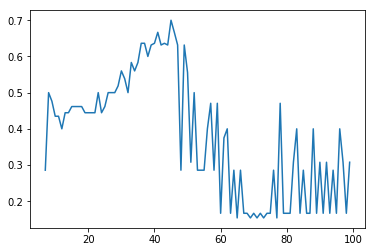

In [52]:
plt.plot(f)
plt.show()